In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

LOAD DATASET

In [3]:
df_fgroup = pd.read_csv('./COVID-19-Dataset/full_grouped.csv')

df_fgroup.head(10)

,Date,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,WHO Region
0,2020-01-22,Afghanistan,0,0,0,0,0,0,0,Eastern Mediterranean
1,2020-01-22,Albania,0,0,0,0,0,0,0,Europe
2,2020-01-22,Algeria,0,0,0,0,0,0,0,Africa
3,2020-01-22,Andorra,0,0,0,0,0,0,0,Europe
4,2020-01-22,Angola,0,0,0,0,0,0,0,Africa
5,2020-01-22,Antigua and Barbuda,0,0,0,0,0,0,0,Americas
6,2020-01-22,Argentina,0,0,0,0,0,0,0,Americas
7,2020-01-22,Armenia,0,0,0,0,0,0,0,Europe
8,2020-01-22,Australia,0,0,0,0,0,0,0,Western Pacific
9,2020-01-22,Austria,0,0,0,0,0,0,0,Europe


ANALYSIS

In [4]:
df_fgroup.shape

(35156, 10)

In [ ]:
countries = df_fgroup['Country/Region'].unique() # Get the unique countries
n_countries = len(countries)
print(f'Number of Country/Region: {n_countries}')

Number of Country/Region: 187


In [6]:
dates = sorted(df_fgroup['Date'].unique()) # Get the unique dates and sort them
print(f'Start date: {dates[0]} -> End date: {dates[-1]}')

Start date: 2020-01-22 -> End date: 2020-07-27


In [ ]:
df_fgroup.isnull().sum() # Check for missing values

Date              0
Country/Region    0
Confirmed         0
Deaths            0
Recovered         0
Active            0
New cases         0
New deaths        0
New recovered     0
WHO Region        0
dtype: int64

In [8]:
df_fgroup.duplicated().sum() # Check for duplicates

np.int64(0)

In [9]:
df_target_recover = df_fgroup.groupby('Country/Region')['Recovered'].sum().reset_index() 
# Group by 'Country/Region' and sum 'Recovered'
df_target_recover.sort_values(by = 'Recovered', ascending = False).head() 
# Sort by 'Recovered' in descending order and display the first 5 rows

,Country/Region,Recovered
173,US,56353416
23,Brazil,54492873
138,Russia,25120448
79,India,23783720
65,Germany,17107839


In [11]:
us_cases = df_fgroup[df_fgroup['Country/Region'] == 'US'].groupby('Country/Region')[['Confirmed', 'Recovered', 'Deaths', 'Active']].sum().reset_index()
# Show information in US
us_cases

,Country/Region,Confirmed,Recovered,Deaths,Active
0,US,224345948,56353416,11011411,156981121


Text(0, 0.5, 'Number of Cases')

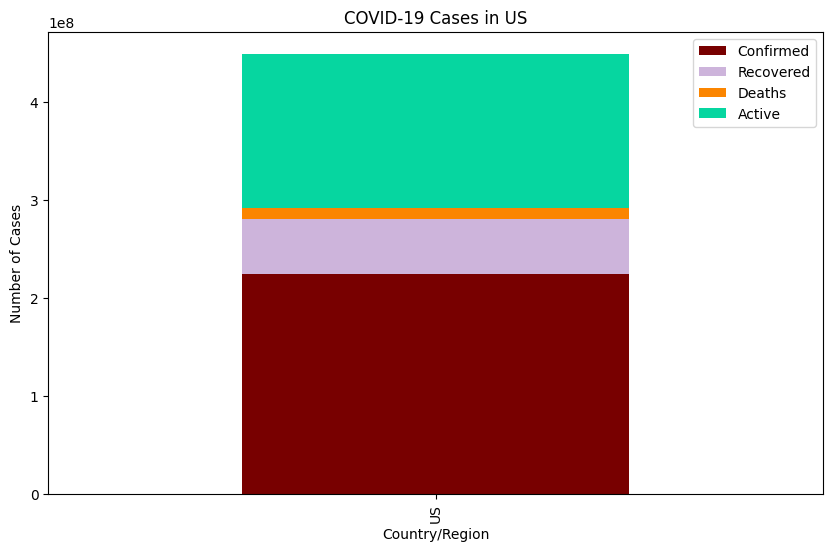

In [ ]:
# Plot the number of cases in US
us_cases.set_index('Country/Region', inplace=True)
pp = ['#780000', '#cdb4db','#fb8500', '#06d6a0']
ax = us_cases[['Confirmed','Recovered', 'Deaths', 'Active']].plot(kind='bar', stacked=True, figsize=(10, 6),color = pp )
plt.title('COVID-19 Cases in US')
plt.xlabel('Country/Region')
plt.ylabel('Number of Cases')

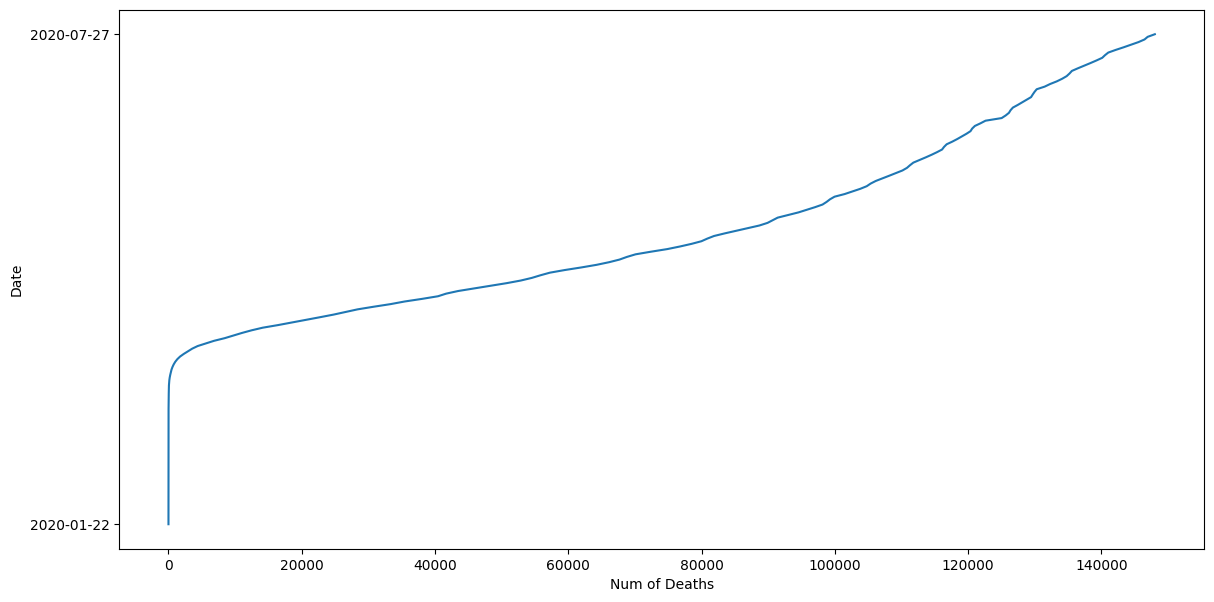

In [14]:
us_info =  df_fgroup[df_fgroup['Country/Region'] == 'US']

# Visualize
plt.figure(figsize=(14, 7))
plt.plot(us_info['Deaths'], us_info['Date'])
plt.xlabel('Num of Deaths')
plt.ylabel('Date')
plt.yticks([us_info['Date'].iloc[0], us_info['Date'].iloc[-1]])
plt.show()

DEATH FORECASTING IN US

In [16]:
country_name = 'US'
country_info = df_fgroup[df_fgroup['Country/Region'] == country_name]
country_info

,Date,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,WHO Region
173,2020-01-22,US,1,0,0,1,0,0,0,Americas
360,2020-01-23,US,1,0,0,1,0,0,0,Americas
547,2020-01-24,US,2,0,0,2,1,0,0,Americas
734,2020-01-25,US,2,0,0,2,0,0,0,Americas
921,2020-01-26,US,5,0,0,5,3,0,0,Americas
...,...,...,...,...,...,...,...,...,...,...
34394,2020-07-23,US,4038816,144430,1233269,2661117,68695,1114,22420,Americas
34581,2020-07-24,US,4112531,145560,1261624,2705347,73715,1130,28355,Americas
34768,2020-07-25,US,4178970,146465,1279414,2753091,66439,905,17790,Americas
34955,2020-07-26,US,4233923,146935,1297863,2789125,54953,470,18449,Americas


In [17]:
data = np.array(country_info['Deaths'].values)

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create sequences of seven consecutive values (X) and the next value (y)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 7
X, y = create_sequences(data, seq_length)

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((126, 7), (126,), (55, 7), (55,))

In [19]:
# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Test the model
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f'Test MSE: {test_mse}')
print(f'Test MAE: {test_mae}')
print(f'Test R²: {test_r2}')

# Print some predictions
print(f'Predictions: {y_test_pred[:10]}')
print(f'Actual values: {y_test[:10]}')

Test MSE: 246064.28028447783
Test MAE: 322.5146545441239
Test R²: 0.998044125890038
Predictions: [108110.90112369 109066.31267272 110069.76535847 110766.74237685
 111295.19854804 111761.67833179 112317.87923343 113629.67265811
 114338.91604917 115220.36176308]
Actual values: [108159 109168 110138 110818 111269 111774 112714 113631 114512 115334]


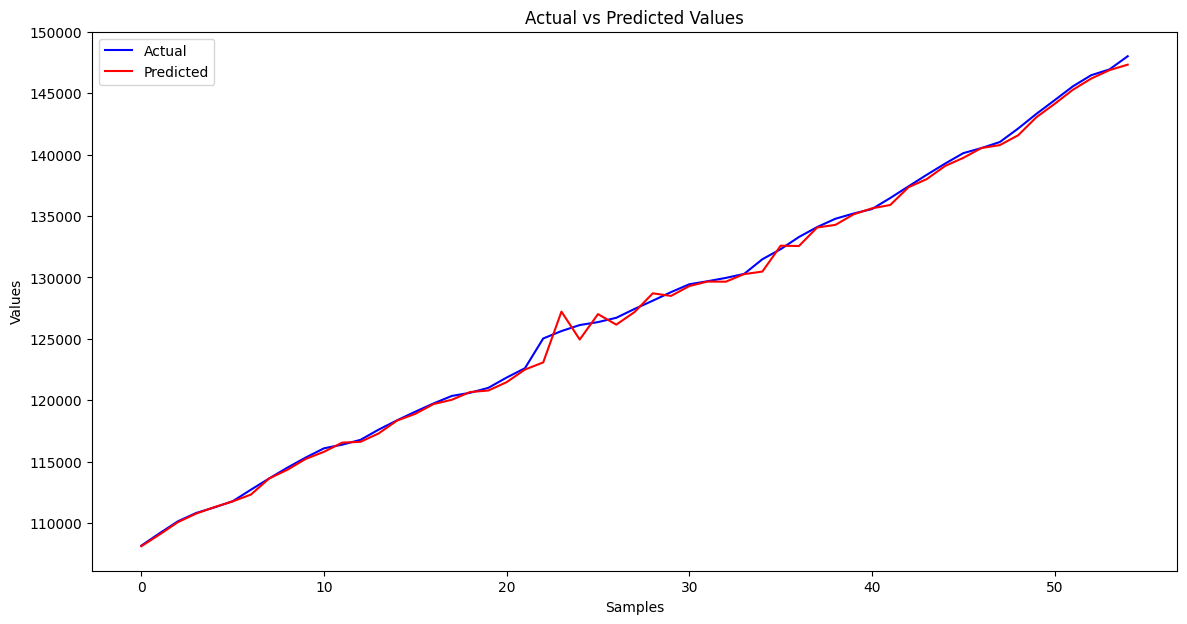

In [ ]:
# Visualize the predictions and actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_test_pred, label='Predicted', color='red')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

RECOVERED PEOPLE FORECASTING IN TOTAL

In [21]:
df_day= pd.read_csv('./COVID-19-Dataset/day_wise.csv')
df_day

,Date,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,No. of countries
0,2020-01-22,555,17,28,510,0,0,0,3.06,5.05,60.71,6
1,2020-01-23,654,18,30,606,99,1,2,2.75,4.59,60.00,8
2,2020-01-24,941,26,36,879,287,8,6,2.76,3.83,72.22,9
3,2020-01-25,1434,42,39,1353,493,16,3,2.93,2.72,107.69,11
4,2020-01-26,2118,56,52,2010,684,14,13,2.64,2.46,107.69,13
...,...,...,...,...,...,...,...,...,...,...,...,...
183,2020-07-23,15510481,633506,8710969,6166006,282756,9966,169714,4.08,56.16,7.27,187
184,2020-07-24,15791645,639650,8939705,6212290,281164,6144,228736,4.05,56.61,7.16,187
185,2020-07-25,16047190,644517,9158743,6243930,255545,4867,219038,4.02,57.07,7.04,187
186,2020-07-26,16251796,648621,9293464,6309711,204606,4104,134721,3.99,57.18,6.98,187


In [22]:
data = np.array(df_day['Recovered'].values)
data

array([     28,      30,      36,      39,      52,      61,     107,
           125,     141,     219,     281,     459,     604,     821,
          1071,    1418,    1903,    2470,    3057,    3714,    4417,
          4849,    5930,    7613,    8902,   10319,   11951,   13693,
         15394,   17369,   17966,   21849,   22304,   24047,   26652,
         29077,   31919,   35306,   38314,   41208,   44085,   46681,
         49619,   52237,   54270,   56760,   59092,   60891,   62802,
         65113,   66434,   68359,   70729,   74139,   76192,   78944,
         81427,   83064,   85509,   89775,   95990,   96456,  105997,
        111445,  119804,  128508,  136800,  146261,  161707,  174074,
        189434,  206052,  221060,  241072,  254477,  270812,  293665,
        322017,  346349,  367477,  392991,  411864,  438395,  463014,
        498925,  529015,  554287,  577789,  608557,  629862,  664043,
        693207,  721689,  771329,  798239,  825969,  852382,  884680,
        925752,  989

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create sequences of seven consecutive values (X) and the next value (y)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 2
X, y = create_sequences(data, seq_length)

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((130, 2), (130,), (56, 2), (56,))

In [24]:
# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Test the model
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f'Test MSE: {test_mse}')
print(f'Test MAE: {test_mae}')
print(f'Test R²: {test_r2}')

# Print some predictions
print(f'Predictions: {y_test_pred[:10]}')
print(f'Actual values: {y_test[:10]}')

Test MSE: 2493905544.85422
Test MAE: 41117.29271228904
Test R²: 0.9993643780239527
Predictions: [2714296.87572155 2831716.30850276 2905891.69382722 2974661.30718197
 3044183.66603084 3117627.84862459 3169421.25600119 3346373.89136625
 3413332.56077236 3492288.24385671]
Actual values: [2743083 2821430 2890776 2959037 3030214 3084718 3235640 3317121 3395154
 3480121]


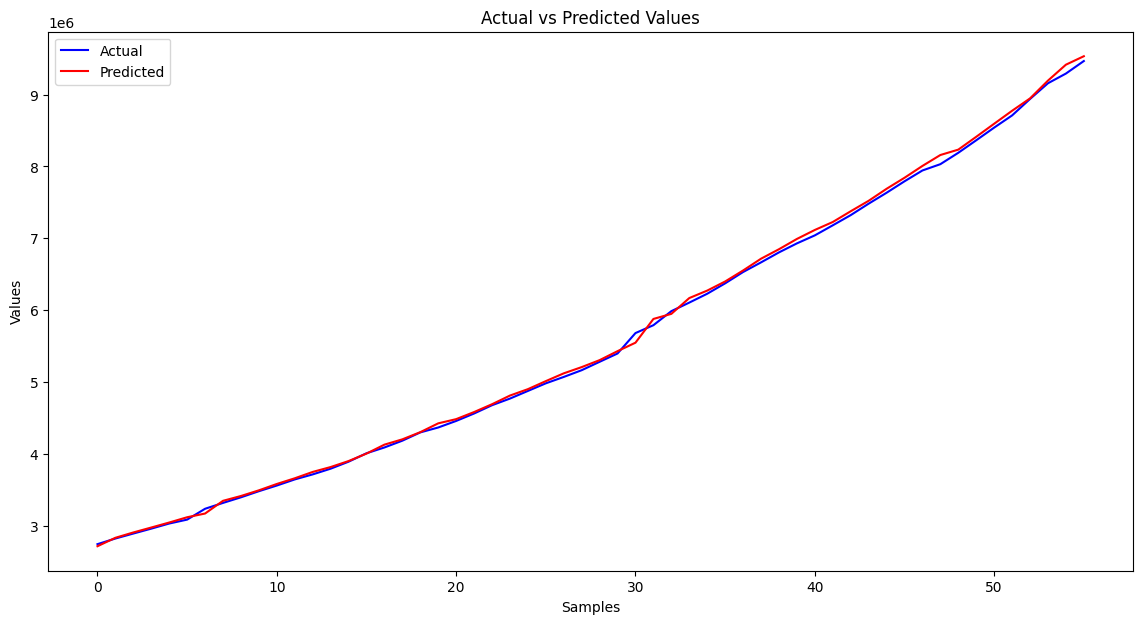

In [25]:
# Visualize the predictions and actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_test_pred, label='Predicted', color='red')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()